<a href="https://colab.research.google.com/github/Rafat97/my-tensorflow/blob/image/Pytorch_Final_Generating_handwritten_digits_DCGAN_GAN_Problem_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import time
import glob
import imageio
from IPython import display
import cv2
import pathlib
import zipfile
import torch
import sys
import pandas as pd 

import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import MNIST

!pip install torchsummary
from torchsummary import summary

!pip install torchviz
from torchviz import make_dot, make_dot_from_trace

     |████████████████████████████████| 51kB 5.5MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=23b048f427c63e8537c46d04b00a5e82089b7ff0f0d4eab66ce03c1216f4ab8d
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [ ]:
def show_tensor_images(epoch, tensor_img, num_img=25, size=(1, 28, 28),nrow= 5):
    # tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], padding=2, normalize=True,nrow=nrow)
    plt.axis('off')
    plt.imshow(img_grid.permute(1, 2, 0).squeeze() , cmap='gray')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# Decide which device we want to run on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
#data load from pytorch
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size=128
z_dim = 100
fixed_noise = torch.randn(batch_size, z_dim, device=device)

train_loader = DataLoader(
    MNIST('data/', download=True, 
    transform=transform),
    batch_size=batch_size,
    shuffle=True)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


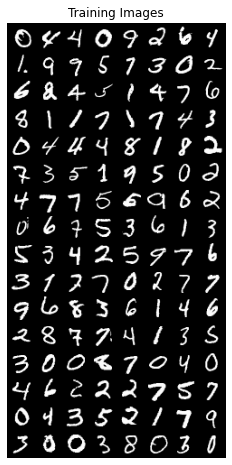

In [ ]:
dataiter = iter(train_loader)
images,labels = dataiter.next()

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(train_loader))

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, img_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim * 2, hidden_dim),
            self.gen_block(hidden_dim, img_channel, kernel_size=4, final_layer=True),
        )

    def gen_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2,inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.Sigmoid()
            )

    def forward(self, x):
        x = x.view(len(x), self.z_dim, 1, 1)      # change the shape: (batch_size, channels=z_dim, width=1, height=1)
        x = self.gen(x)
        return x;

summary(Generator(100).to(device), (100,))

class Discriminator(nn.Module):

    def __init__(self, img_channel=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(img_channel, hidden_dim, kernel_size=4),
            self.disc_block(hidden_dim, hidden_dim * 2),
            self.disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=1),
            self.disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def disc_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.Sigmoid()
            )
  
    def forward(self, image):
        disc_pred = self.disc(image)
        # retval = disc_pred.view(len(disc_pred), -1)
        return   disc_pred  # returns 1-dimension tensor representing fake/real


summary(Discriminator().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         230,656
       BatchNorm2d-2            [-1, 256, 3, 3]             512
         LeakyReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
         LeakyReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         LeakyReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
          Sigmoid-11            [-1, 1, 28, 28]               0
Total params: 830,785
Trainable params: 830,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

netG = Generator(z_dim).to(device)
netD  = Discriminator().to(device)

# netG.apply(weights_init)
# netD.apply(weights_init)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=0.0001)
optimizerG = optim.Adam(netG.parameters(), lr=0.0001)

# noise = torch.randn(batch_size, z_dim, device=device)
# fake_img = netG(noise)
# unflat_img = fake_img.detach().cpu()
# img_grid = make_grid(unflat_img[0])
# plt.imshow(img_grid.permute(1, 2, 0).squeeze() , cmap='gray')


Starting Training Loop...
[0/64][468/469]	Loss_D : 0.7543	Loss_G : 1.3056	D(x):: 0.7254	D(G(z)): 0.3328/0.2743

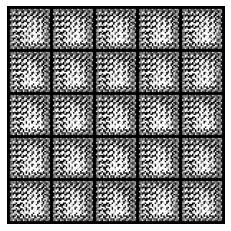

[1/64][468/469]	Loss_D : 0.4384	Loss_G : 1.8011	D(x):: 0.8367	D(G(z)): 0.2101/0.1738

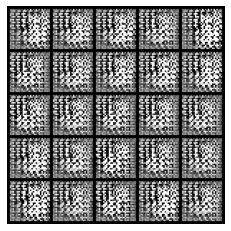

[2/64][468/469]	Loss_D : 0.3312	Loss_G : 2.1084	D(x):: 0.8523	D(G(z)): 0.1481/0.1256

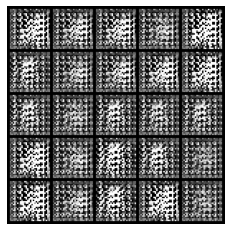

[3/64][468/469]	Loss_D : 0.2778	Loss_G : 2.2440	D(x):: 0.8985	D(G(z)): 0.1464/0.1261

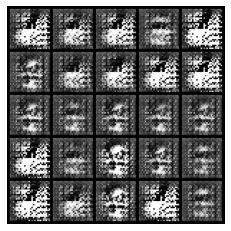

[4/64][468/469]	Loss_D : 0.6725	Loss_G : 1.4532	D(x):: 0.7936	D(G(z)): 0.3263/0.2587

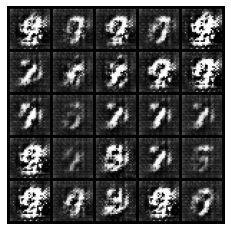

[5/64][468/469]	Loss_D : 0.8700	Loss_G : 1.6172	D(x):: 0.6858	D(G(z)): 0.2934/0.2393

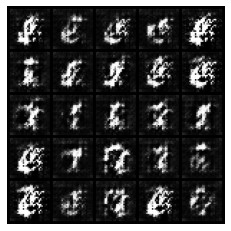

[6/64][468/469]	Loss_D : 0.7027	Loss_G : 1.5418	D(x):: 0.7490	D(G(z)): 0.2882/0.2611

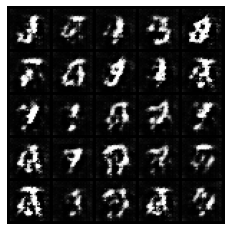

[7/64][468/469]	Loss_D : 0.5375	Loss_G : 1.9272	D(x):: 0.7729	D(G(z)): 0.1932/0.1910

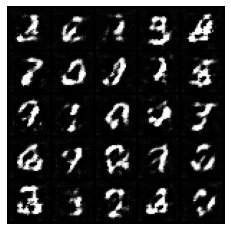

[8/64][468/469]	Loss_D : 0.4175	Loss_G : 2.2374	D(x):: 0.8190	D(G(z)): 0.1718/0.1434

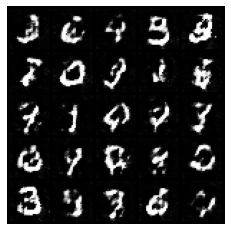

[9/64][468/469]	Loss_D : 0.7025	Loss_G : 1.8387	D(x):: 0.6557	D(G(z)): 0.1782/0.1955

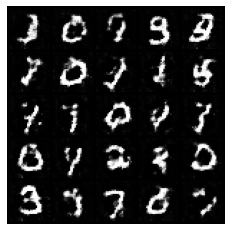

[10/64][468/469]	Loss_D : 0.6272	Loss_G : 1.7715	D(x):: 0.7086	D(G(z)): 0.2002/0.2052

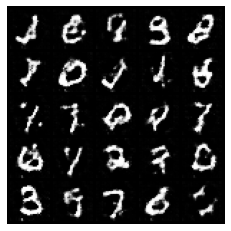

[11/64][468/469]	Loss_D : 0.7267	Loss_G : 1.2740	D(x):: 0.7638	D(G(z)): 0.3244/0.3241

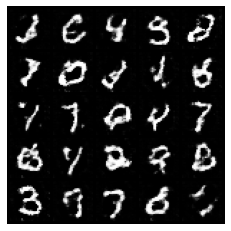

[12/64][468/469]	Loss_D : 0.8131	Loss_G : 1.5775	D(x):: 0.6858	D(G(z)): 0.3043/0.2560

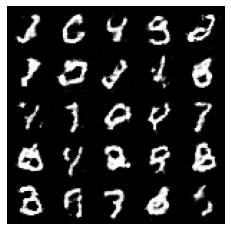

[13/64][468/469]	Loss_D : 0.6966	Loss_G : 1.4692	D(x):: 0.6950	D(G(z)): 0.2295/0.2689

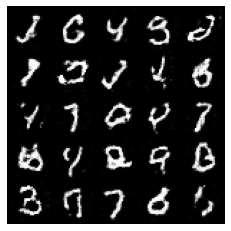

[14/64][468/469]	Loss_D : 1.0160	Loss_G : 1.1165	D(x):: 0.6505	D(G(z)): 0.3949/0.3606

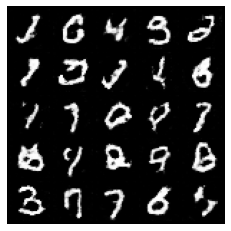

[15/64][468/469]	Loss_D : 0.6458	Loss_G : 1.5565	D(x):: 0.7680	D(G(z)): 0.2802/0.2567

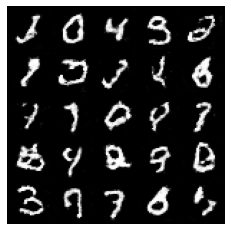

[16/64][468/469]	Loss_D : 0.8089	Loss_G : 1.3871	D(x):: 0.6276	D(G(z)): 0.2373/0.2898

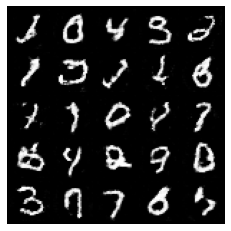

[17/64][468/469]	Loss_D : 0.9440	Loss_G : 1.3223	D(x):: 0.6257	D(G(z)): 0.3218/0.3184

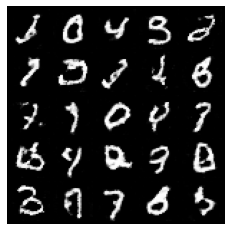

[18/64][468/469]	Loss_D : 0.7464	Loss_G : 1.5077	D(x):: 0.7007	D(G(z)): 0.2765/0.2623

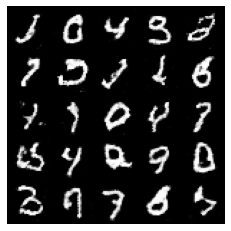

[19/64][468/469]	Loss_D : 0.8468	Loss_G : 1.3868	D(x):: 0.6345	D(G(z)): 0.2599/0.2965

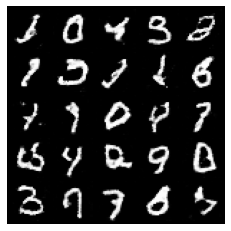

[20/64][468/469]	Loss_D : 0.6540	Loss_G : 1.6100	D(x):: 0.7562	D(G(z)): 0.2712/0.2472

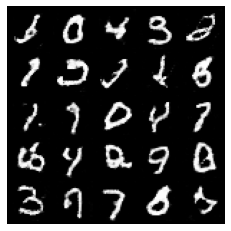

[21/64][468/469]	Loss_D : 0.6776	Loss_G : 1.6094	D(x):: 0.7469	D(G(z)): 0.2812/0.2452

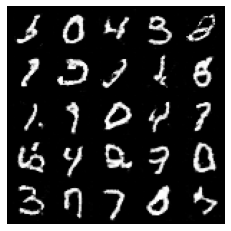

[22/64][468/469]	Loss_D : 0.7907	Loss_G : 1.2636	D(x):: 0.7001	D(G(z)): 0.3129/0.3203

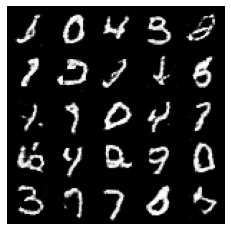

[23/64][468/469]	Loss_D : 0.7903	Loss_G : 1.1987	D(x):: 0.8059	D(G(z)): 0.3945/0.3455

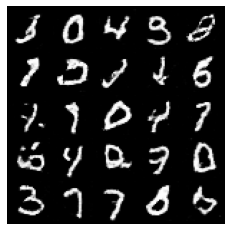

[24/64][468/469]	Loss_D : 0.8031	Loss_G : 1.2355	D(x):: 0.6906	D(G(z)): 0.3056/0.3336

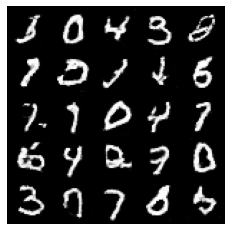

[25/64][468/469]	Loss_D : 0.7467	Loss_G : 1.4159	D(x):: 0.7455	D(G(z)): 0.3139/0.2896

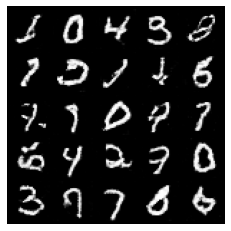

[26/64][468/469]	Loss_D : 0.7866	Loss_G : 1.4184	D(x):: 0.7193	D(G(z)): 0.3209/0.2981

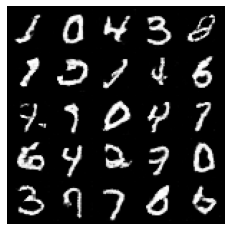

[27/64][468/469]	Loss_D : 0.8438	Loss_G : 1.8032	D(x):: 0.6075	D(G(z)): 0.2264/0.2184

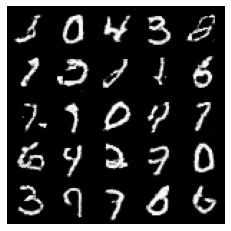

[28/64][468/469]	Loss_D : 0.8731	Loss_G : 1.1166	D(x):: 0.7672	D(G(z)): 0.3961/0.3829

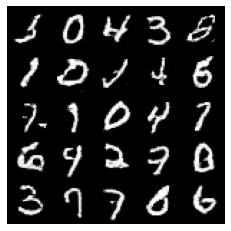

[29/64][468/469]	Loss_D : 0.6900	Loss_G : 1.4858	D(x):: 0.7228	D(G(z)): 0.2712/0.2758

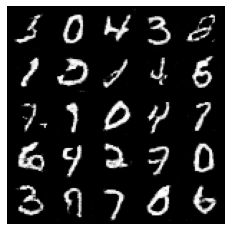

[30/64][468/469]	Loss_D : 0.6892	Loss_G : 1.3729	D(x):: 0.8344	D(G(z)): 0.3523/0.3103

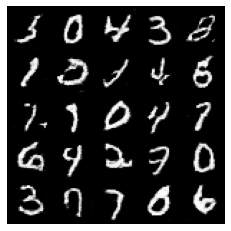

[31/64][468/469]	Loss_D : 0.7159	Loss_G : 1.3346	D(x):: 0.7570	D(G(z)): 0.3083/0.3241

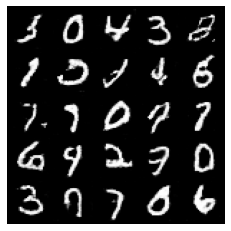

[32/64][468/469]	Loss_D : 0.7126	Loss_G : 1.6204	D(x):: 0.7282	D(G(z)): 0.2698/0.2396

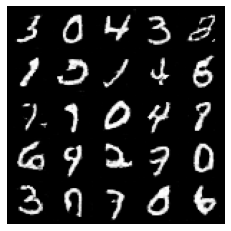

[33/64][468/469]	Loss_D : 0.6730	Loss_G : 1.3008	D(x):: 0.8052	D(G(z)): 0.3170/0.3242

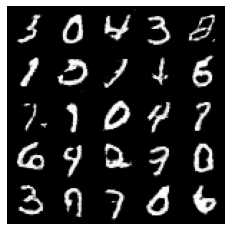

[34/64][468/469]	Loss_D : 0.6513	Loss_G : 1.6836	D(x):: 0.7008	D(G(z)): 0.2044/0.2243

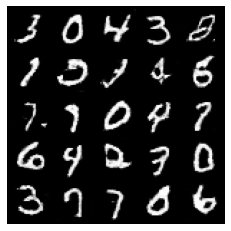

[35/64][468/469]	Loss_D : 1.1219	Loss_G : 1.4017	D(x):: 0.5101	D(G(z)): 0.2592/0.2970

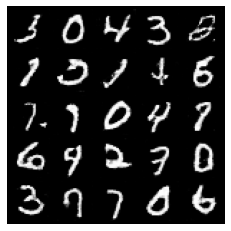

[36/64][468/469]	Loss_D : 0.8733	Loss_G : 1.4153	D(x):: 0.6643	D(G(z)): 0.3211/0.2869

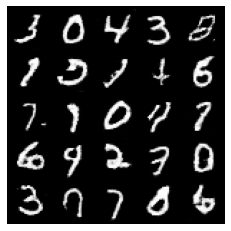

[37/64][468/469]	Loss_D : 0.7376	Loss_G : 1.4331	D(x):: 0.6505	D(G(z)): 0.2223/0.2850

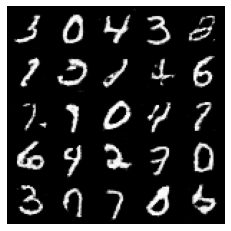

[38/64][468/469]	Loss_D : 0.6793	Loss_G : 1.5151	D(x):: 0.7112	D(G(z)): 0.2343/0.2817

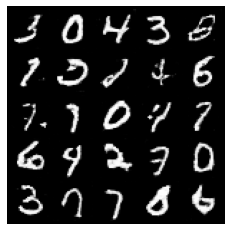

[39/64][468/469]	Loss_D : 0.9115	Loss_G : 1.4125	D(x):: 0.7328	D(G(z)): 0.3649/0.3270

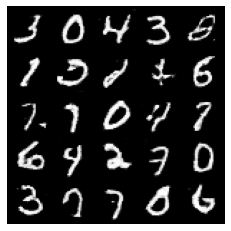

[40/64][468/469]	Loss_D : 0.7710	Loss_G : 1.6001	D(x):: 0.7001	D(G(z)): 0.2903/0.2605

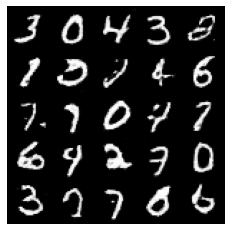

[41/64][468/469]	Loss_D : 0.7465	Loss_G : 1.2534	D(x):: 0.8598	D(G(z)): 0.4040/0.3366

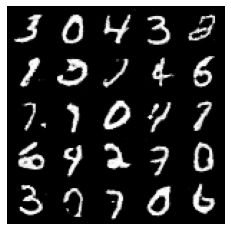

[42/64][468/469]	Loss_D : 0.7800	Loss_G : 1.4624	D(x):: 0.7134	D(G(z)): 0.3002/0.2928

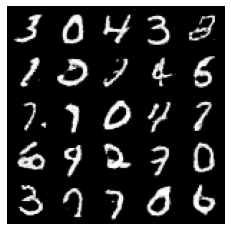

[43/64][468/469]	Loss_D : 0.5942	Loss_G : 2.0226	D(x):: 0.7149	D(G(z)): 0.1871/0.1753

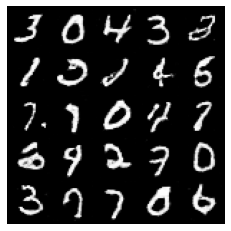

[44/64][468/469]	Loss_D : 0.7565	Loss_G : 1.2878	D(x):: 0.7514	D(G(z)): 0.3366/0.3218

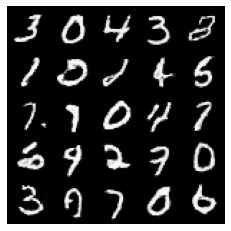

[45/64][468/469]	Loss_D : 0.8417	Loss_G : 1.6022	D(x):: 0.6466	D(G(z)): 0.2707/0.2548

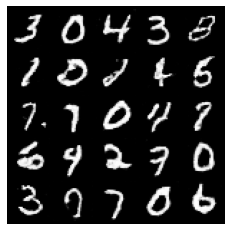

[46/64][468/469]	Loss_D : 1.0138	Loss_G : 1.1503	D(x):: 0.6398	D(G(z)): 0.3567/0.3742

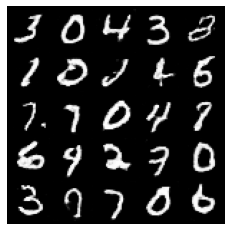

[47/64][468/469]	Loss_D : 1.3756	Loss_G : 1.3921	D(x):: 0.4443	D(G(z)): 0.2793/0.3247

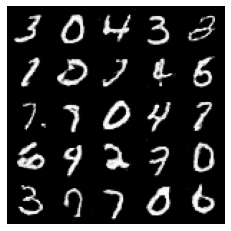

[48/64][468/469]	Loss_D : 0.9112	Loss_G : 1.0420	D(x):: 0.8022	D(G(z)): 0.4430/0.3989

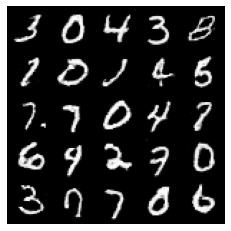

[49/64][468/469]	Loss_D : 0.9091	Loss_G : 1.4425	D(x):: 0.6414	D(G(z)): 0.3007/0.2899

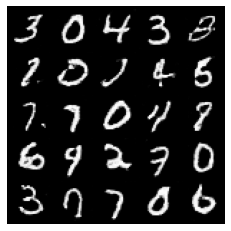

[50/64][468/469]	Loss_D : 1.0443	Loss_G : 1.4480	D(x):: 0.5933	D(G(z)): 0.3276/0.3112

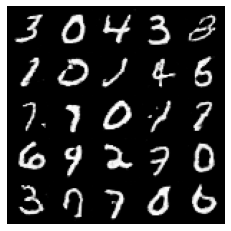

[51/64][468/469]	Loss_D : 0.7805	Loss_G : 1.6254	D(x):: 0.6562	D(G(z)): 0.2370/0.2532

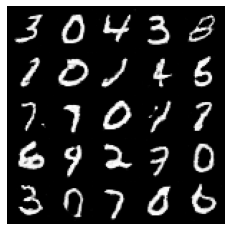

[52/64][468/469]	Loss_D : 0.8089	Loss_G : 1.0541	D(x):: 0.7742	D(G(z)): 0.3791/0.3928

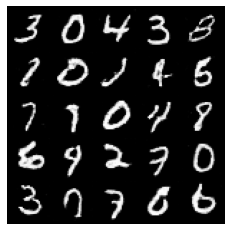

[53/64][468/469]	Loss_D : 0.9932	Loss_G : 1.1326	D(x):: 0.6722	D(G(z)): 0.3772/0.3864

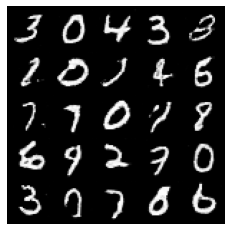

[54/64][468/469]	Loss_D : 0.7521	Loss_G : 1.4534	D(x):: 0.7339	D(G(z)): 0.3116/0.2803

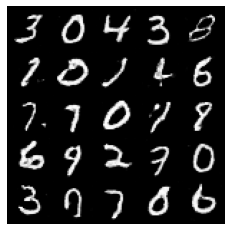

[55/64][468/469]	Loss_D : 0.7036	Loss_G : 1.8081	D(x):: 0.6862	D(G(z)): 0.2297/0.2126

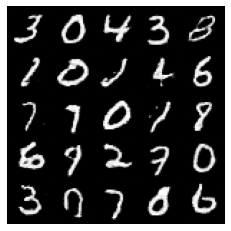

[56/64][468/469]	Loss_D : 0.6570	Loss_G : 1.3906	D(x):: 0.7350	D(G(z)): 0.2290/0.2966

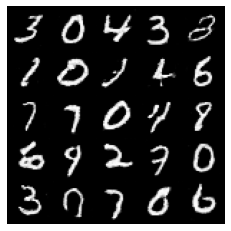

[57/64][468/469]	Loss_D : 0.9030	Loss_G : 1.4687	D(x):: 0.6222	D(G(z)): 0.2733/0.2934

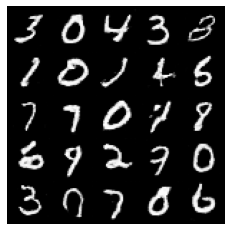

[58/64][468/469]	Loss_D : 0.9945	Loss_G : 0.9551	D(x):: 0.7728	D(G(z)): 0.4532/0.4494

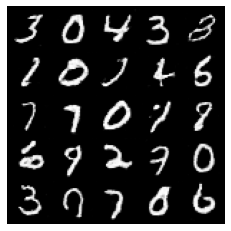

[59/64][468/469]	Loss_D : 0.9306	Loss_G : 1.3364	D(x):: 0.6863	D(G(z)): 0.3615/0.3313

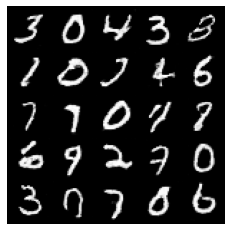

[60/64][468/469]	Loss_D : 1.0438	Loss_G : 1.3546	D(x):: 0.5955	D(G(z)): 0.3215/0.3213

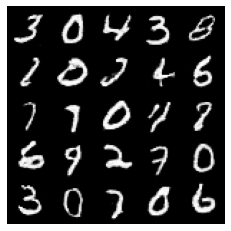

[61/64][468/469]	Loss_D : 0.8322	Loss_G : 1.1980	D(x):: 0.7127	D(G(z)): 0.3277/0.3640

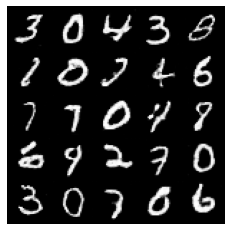

[62/64][468/469]	Loss_D : 1.0076	Loss_G : 1.4180	D(x):: 0.5696	D(G(z)): 0.2855/0.3045

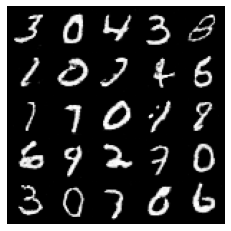

[63/64][468/469]	Loss_D : 0.7365	Loss_G : 1.3189	D(x):: 0.7575	D(G(z)): 0.3140/0.3381

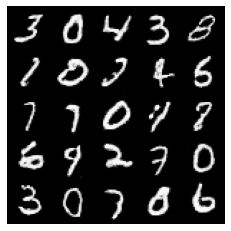

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
epochs = 64
display_step = len(train_loader)
# Training Loop


print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(0.)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(1.)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        print_val = f"[{epoch}/{epochs}][{i}/{len(train_loader)}]\t"
        print_val += f"Loss_D : {errD.item():.4f}\t"
        print_val += f"Loss_G : {errG.item():.4f}\t"
        print_val += f"D(x):: {D_x:.4f}\t"
        print_val += f"D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}"

        sys.stdout.write('\r' + str(print_val))


        # Output training stats
        if i % display_step == 0 and i != 0:
            print()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1
    
    with torch.no_grad():
      fake = netG(fixed_noise).detach().cpu()
    show_tensor_images(epoch , fake)
    # img_list.append(make_grid(fake, padding=2, normalize=True))

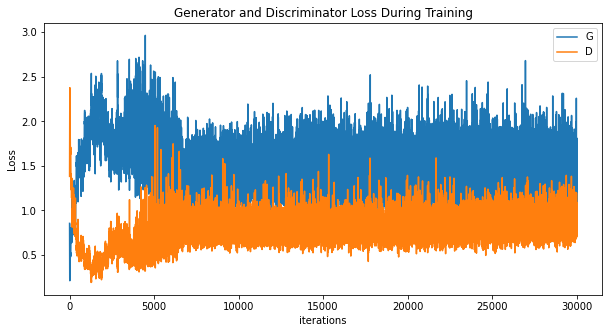

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

     |████████████████████████████████| 1.0MB 8.0MB/s 



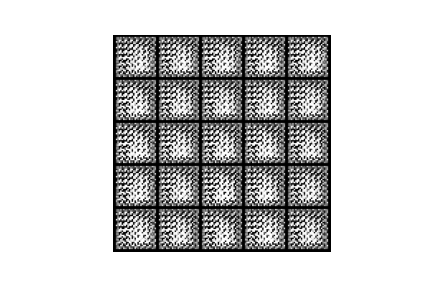

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

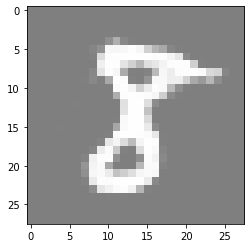

In [ ]:
def show_new_gen_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

num_image = 1
noise = torch.randn(num_image, z_dim, device=device)
with torch.no_grad():
    fake_img = netG(noise)

show_new_gen_images(fake_img)